# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy
import glob

import numpy as np
import pandas as pd

from astropy.io  import fits
from astropy     import units as u
from astropy.wcs import WCS
from astropy.io.votable import parse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import mean_squared_error

from spectral_cube import SpectralCube

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct256_checkpoint_path  = checkpoint_path / 'c256_1split'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'
sponge_data_path = data_path / 'sponge'


tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'
bighicat = tanosignal_path / 'bighicat'

saury2014_data_path = data_path / 'saury'
seta222_data_path = data_path / 'seta'

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]

    dat.close()

    print(f"Cube shape: {c.shape}") # (vlsr, b, l)

    del dat

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

# Read BIGHICAT

In [ ]:
bighicat_csvfile = bighicat / 'all_unique_LOS_BIGHICAT.csv'
bighicat_df = pd.read_csv(bighicat_csvfile)
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,e_f_CNM_LOS_KOK14,nhi_thin,signhi_thin,rhi,sigrhi,rhi_ctrans,sigrhi_ctrans,fcnm_ctrans,sigfcnm_ctrans,"Note v1, v2, noise"
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.034327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.263721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.258198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.045187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.047690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# MACH

In [ ]:
mach_csvfile = bighicat / 'mach_los.csv'
mdf = pd.read_csv(mach_csvfile)
print(mdf.shape)
msrcs = np.sort(mdf.source.values)
mdf

(147, 12)


,source,survey,glon,glat,nhithin,signhithin,nhi,signhi,rhi,sigrhi,fcnm,sigfcnm
0,J14002,MACH,109.589,53.127,1.40,0.11,1.40,0.11,1.00,0.11,0.00,0.00
1,J14364,MACH,105.174,49.730,1.30,0.08,1.30,0.08,1.00,0.09,0.00,0.00
2,J14384,MACH,103.524,50.695,1.50,0.13,1.50,0.13,1.00,0.12,0.00,0.00
3,J14434,MACH,88.257,58.314,2.29,0.23,2.29,0.23,1.00,0.14,0.01,0.02
4,J14510,MACH,71.913,61.477,1.46,0.05,1.47,0.05,1.00,0.05,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
142,P0347+05,HT03,182.274,-35.731,12.76,0.25,15.34,0.32,1.20,0.03,0.28,0.10
143,P0428+20,HT03,176.808,-18.557,19.30,0.62,28.01,0.80,1.45,0.04,0.43,0.16
144,P0820+22,HT03,201.364,29.676,4.86,0.14,4.88,0.14,1.00,0.04,0.08,0.04
145,P1055+20,HT03,222.510,63.130,1.66,0.07,1.67,0.08,1.01,0.06,0.08,0.04


In [ ]:
mach_df = bighicat_df[bighicat_df.survey == 'MACH']
machsrcs = np.sort(mach_df.source.values)
print(mach_df.shape)
mach_df

(44, 39)


,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,e_f_CNM_LOS_KOK14,nhi_thin,signhi_thin,rhi,sigrhi,rhi_ctrans,sigrhi_ctrans,fcnm_ctrans,sigfcnm_ctrans,"Note v1, v2, noise"
329,3C345,MACH,63.4547,40.9491,250.744686,39.810053,0.87,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,J14002,MACH,109.5893,53.1269,210.117680,62.176486,1.40,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,J14364,MACH,105.1741,49.7301,219.189415,63.609852,1.30,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,J14384,MACH,103.5245,50.6949,219.685029,62.197720,1.50,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,J14434,MACH,88.2567,58.3145,220.929723,50.575399,2.29,0.01,0.99,0.0229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,J14510,MACH,71.9133,61.4769,222.779993,41.911384,1.47,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,J14540,MACH,85.6719,57.2490,223.534661,50.058387,1.35,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336,J15040,MACH,97.6908,50.1064,226.037044,60.014732,1.11,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,J15075,MACH,99.7852,48.3101,226.987423,62.225532,1.32,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,J15102,MACH,87.3187,53.6847,227.584006,52.741613,1.70,0.00,1.00,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# SPONGE

In [ ]:
sponge_df = bighicat_df[bighicat_df.survey == '21-SPONGE']
sponge_df

In [ ]:
sp_votfile = bighicat / '21SPONGE.vot'
print(sp_votfile)
spdf = pd.read_csv(sp_votfile)
spdf['Name'] = spdf['Name'].apply(lambda x: x.replace(' ', ''))
spdf

/content/gdrive/MyDrive/Colab Notebooks/ML_HI/tano_signal/bighicat/21SPONGE.vot


,NVSS,Name,Rej,RAJ2000,DEJ2000,S1.4GHz,Beam1,Beam2,errTau,TauPk,...,sigrhi,nhicnm,signhicnm,fcnm,sigfcnm,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl
0,1,J0022,NaN,00 22 25.4,+00 14 56.2,3.01,2.2,1.4,0.8,0.025,...,0.061310,0.110000,0.000000,0.041825,0.001272,1.004219,0.002808,0.038753,0.025516,"-50.0, 35.0, 0.0"
1,1,3C018A,NaN,00 40 50.7,+10 03 05.0,4.60,15.5,13.7,1.5,0.623,...,0.042943,3.290000,0.136015,0.490313,0.026804,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0"
2,1,3C018B,NaN,00 40 49.5,+10 03 50.0,4.60,15.5,13.7,2.4,0.642,...,0.042938,3.300000,0.116619,0.494753,0.024952,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0"
3,1,3C041A,NaN,01 26 44.8,+33 13 02.3,3.71,1.7,1.4,2.4,0.039,...,0.047164,2.010000,0.070711,0.368132,0.014924,1.031608,0.015288,0.308975,0.034697,"-90.0, 50.0, 0.0"
4,1,3C041B,NaN,01 26 43.8,+33 13 21.8,3.71,1.7,1.4,3.8,0.057,...,0.045141,0.880000,0.050000,0.160878,0.009439,1.023121,0.016231,0.276679,0.055719,"-80.0, 40.0, 0.0"
5,1,3C48,NaN,01 37 41.3,+33 09 35.1,16.02,1.3,1.2,0.7,0.050,...,0.062728,1.680000,0.028284,0.394366,0.008094,1.045387,0.007786,0.417322,0.016107,"-90.0, 80.0, 0.0"
6,1,4C15.05,NaN,02 04 50.4,+15 14 11.0,4.07,3.3,3.0,0.6,0.086,...,0.067044,3.500000,0.132288,0.791855,0.052388,1.091353,0.038550,0.595234,0.014628,"-90.0, 80.0, 0.0"
7,2,3C78,NaN,03 08 26.2,+04 06 39.0,5.75,4.1,2.2,2.2,1.366,...,0.093420,7.600000,0.510392,0.668426,0.067611,1.252841,0.059012,0.617025,0.009583,"-90.0, 80.0, 0.0"
8,1,4C16.09,NaN,03 18 57.8,+16 28 32.7,8.03,1.4,1.2,0.6,0.539,...,0.033781,6.730000,0.160935,0.615736,0.021578,1.339372,0.022660,0.723655,0.031929,"-80.0, 80.0, 0.0"
9,1,3C111A,NaN,04 18 21.3,+38 01 35.8,7.73,13.0,5.3,1.7,0.888,...,0.079334,20.520000,0.721526,0.717483,0.040247,1.716662,0.284000,0.800403,0.092686,"-80.0, 80.0, 0.0"


In [ ]:
assert np.all(np.sort(spdf.Name.values) == np.sort(sponge_df.source.values))

In [ ]:
sp_gcomp_votfile = bighicat / 'spong21_gcomp.vot'
sp_gcomp_df = votable_to_pandas(sp_gcomp_votfile)
sp_gcomp_df['Name'] = sp_gcomp_df['Name'].apply(lambda x: x.replace(' ', ''))
sp_gcomp_df

,recno,Name,tau0,e_tau0,Delnu0,e_Delnu0,nu0,e_nu0,TBn,e_TBn,Delnu0n,e_Delnu0n,nu0n,e_nu0n,Ts,e_Ts,NHI,e_NHI,O,f
0,1,J0022,0.018,0.001,2.8,0.1,-7.8,0.1,1.500000,0.0,3.1,0.1,-7.8,0.1,83,2,0.08,0.00,4,0.0
1,2,J0022,0.008,0.001,10.3,0.3,-4.3,0.2,4.400000,0.1,11.4,0.1,-4.1,0.1,567,19,0.88,0.05,4,NaN
2,3,J0022,0.009,0.001,1.7,0.1,0.3,0.1,0.800000,0.0,1.8,0.1,0.3,0.1,84,4,0.03,0.00,4,NaN
3,4,J0022,0.003,0.001,1.0,0.2,-14.6,0.1,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,NaN
4,5,3C018A,0.565,0.007,2.5,0.1,-9.1,0.1,6.900000,0.1,3.0,0.1,-10.3,0.1,17,1,0.48,0.04,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,280,3C459,0.057,0.002,1.9,0.1,0.4,0.1,2.700000,0.1,2.0,0.1,0.4,0.1,37,8,0.08,0.02,7,NaN
280,281,3C459,0.039,0.003,7.7,0.6,0.8,0.3,18.299999,1.4,7.7,0.1,0.7,0.1,478,35,2.79,0.37,7,NaN
281,282,3C459,0.088,0.003,2.2,0.1,2.9,0.1,3.500000,0.1,2.2,0.1,2.9,0.1,46,6,0.18,0.03,7,NaN
282,283,3C459,0.016,0.001,1.4,0.1,7.7,0.1,0.900000,0.0,1.6,0.1,7.7,0.1,56,2,0.03,0.00,7,NaN


In [ ]:
sp_gcomp_df = sp_gcomp_df.fillna(0)
sp_gcomp_df

,recno,Name,tau0,e_tau0,Delnu0,e_Delnu0,nu0,e_nu0,TBn,e_TBn,Delnu0n,e_Delnu0n,nu0n,e_nu0n,Ts,e_Ts,NHI,e_NHI,O,f
0,1,J0022,0.018,0.001,2.8,0.1,-7.8,0.1,1.500000,0.0,3.1,0.1,-7.8,0.1,83,2,0.08,0.00,4,0.0
1,2,J0022,0.008,0.001,10.3,0.3,-4.3,0.2,4.400000,0.1,11.4,0.1,-4.1,0.1,567,19,0.88,0.05,4,0.0
2,3,J0022,0.009,0.001,1.7,0.1,0.3,0.1,0.800000,0.0,1.8,0.1,0.3,0.1,84,4,0.03,0.00,4,0.0
3,4,J0022,0.003,0.001,1.0,0.2,-14.6,0.1,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0.00,0,0.0
4,5,3C018A,0.565,0.007,2.5,0.1,-9.1,0.1,6.900000,0.1,3.0,0.1,-10.3,0.1,17,1,0.48,0.04,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,280,3C459,0.057,0.002,1.9,0.1,0.4,0.1,2.700000,0.1,2.0,0.1,0.4,0.1,37,8,0.08,0.02,7,0.0
280,281,3C459,0.039,0.003,7.7,0.6,0.8,0.3,18.299999,1.4,7.7,0.1,0.7,0.1,478,35,2.79,0.37,7,0.0
281,282,3C459,0.088,0.003,2.2,0.1,2.9,0.1,3.500000,0.1,2.2,0.1,2.9,0.1,46,6,0.18,0.03,7,0.0
282,283,3C459,0.016,0.001,1.4,0.1,7.7,0.1,0.900000,0.0,1.6,0.1,7.7,0.1,56,2,0.03,0.00,7,0.0


In [ ]:
src_list = sponge_df.source.values.tolist()
src_list = spdf.Name.values.tolist()
nsrc = len(src_list)
print(nsrc)
print(src_list[:3])

56
['J0022', '3C018A', '3C018B']


# SPONGE21: Read predicted values

In [ ]:
sp_csvfile = bighicat / '21SPONGE_rl_ew.csv'
spdf = pd.read_csv(sp_csvfile)

df = spdf[np.abs(spdf.lat) > 15.]
df = df.drop([27, 41]) # Drop 3C245B, J1613 (no result)
df

,NVSS,Name,Rej,RAJ2000,DEJ2000,S1.4GHz,Beam1,Beam2,errTau,TauPk,...,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl,lon,lat,ew,sigew,taupeak
0,1,J0022,NaN,00 22 25.4,+00 14 56.2,3.01,2.2,1.4,0.8,0.025,...,1.004219,0.002808,0.038753,0.025516,"-50.0, 35.0, 0.0",107.461730,-61.748239,0.152596,0.006093,0.025008
1,1,3C018A,NaN,00 40 50.7,+10 03 05.0,4.60,15.5,13.7,1.5,0.623,...,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0",118.623255,-52.731718,2.388960,0.012099,0.623266
2,1,3C018B,NaN,00 40 49.5,+10 03 50.0,4.60,15.5,13.7,2.4,0.642,...,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0",118.616421,-52.718907,2.350025,0.018069,0.646219
3,1,3C041A,NaN,01 26 44.8,+33 13 02.3,3.71,1.7,1.4,2.4,0.039,...,1.031608,0.015288,0.308975,0.034697,"-90.0, 50.0, 0.0",131.378783,-29.074651,0.425712,0.019103,0.039869
4,1,3C041B,NaN,01 26 43.8,+33 13 21.8,3.71,1.7,1.4,3.8,0.057,...,1.023121,0.016231,0.276679,0.055719,"-80.0, 40.0, 0.0",131.373859,-29.069848,0.414389,0.028003,0.058592
5,1,3C48,NaN,01 37 41.3,+33 09 35.1,16.02,1.3,1.2,0.7,0.050,...,1.045387,0.007786,0.417322,0.016107,"-90.0, 80.0, 0.0",133.962566,-28.719406,0.397174,0.006316,0.050649
6,1,4C15.05,NaN,02 04 50.4,+15 14 11.0,4.07,3.3,3.0,0.6,0.086,...,1.091353,0.038550,0.595234,0.014628,"-90.0, 80.0, 0.0",147.930237,-44.043499,0.737596,0.005587,0.086753
7,2,3C78,NaN,03 08 26.2,+04 06 39.0,5.75,4.1,2.2,2.2,1.366,...,1.252841,0.059012,0.617025,0.009583,"-90.0, 80.0, 0.0",174.858069,-44.513511,4.984242,0.019157,1.366020
8,1,4C16.09,NaN,03 18 57.8,+16 28 32.7,8.03,1.4,1.2,0.6,0.539,...,1.339372,0.022660,0.723655,0.031929,"-80.0, 80.0, 0.0",166.635682,-33.595918,3.007419,0.006053,0.539776
12,1,3C120,NaN,04 33 11.1,+05 21 15.6,3.44,4.7,4.3,0.9,2.033,...,1.803077,0.128603,0.781437,0.050840,"-80.0, 80.0, 0.0",-169.627134,-27.396853,10.643895,0.008556,2.037051


In [ ]:
sp21_fcnm    = df['fcnm'].values
sp21_sigfcnm = df['sigfcnm'].values

ct_fcnm    = df['fcnm_rl'].values
ct_sigfcnm = df['sigfcnm_rl'].values

sp21_rhi    = df['rhi'].values
sp21_sigrhi = df['sigrhi'].values

sp21_lat = np.abs(df.lat.values)

ct_rhi    = df['rhi_rl'].values
ct_sigrhi = df['sigrhi_rl'].values

nhitot = df.NHItot.values
signhitot = df.e_NHItot.values
nhithin = df.NHIthin.values
signhithin = df.e_NHIthin.values

sp21_ew = df.ew.values
sp21_sigew = df.sigew.values
sp21_taupeak = df.taupeak.values

hgl_srcs = df.Name.values
hgl_srcs

# MACH

In [ ]:
mach_csvfile = bighicat / 'mach_los_rl_ew.csv'
mdf = pd.read_csv(mach_csvfile)
mdf

In [ ]:
m_fcnm    = mdf['fcnm'].values
m_sigfcnm = mdf['sigfcnm'].values

ctm_fcnm    = mdf['fcnm_rl'].values
ctm_sigfcnm = mdf['sigfcnm_rl'].values

m_rhi    = mdf['rhi'].values
m_sigrhi = mdf['sigrhi'].values

m_lat = np.abs(mdf.glat.values)

ctm_rhi    = mdf['rhi_rl'].values
ctm_sigrhi = mdf['sigrhi_rl'].values

nhitot_m = mdf.nhi.values
signhitot_m = mdf.signhi.values

nhithin_m = mdf.nhithin.values
signhithin_m = mdf.signhithin.values


m_ew = mdf.ew.values
m_sigew = mdf.sigew.values
m_taupeak = mdf.taupeak.values

mhgl_srcs = mdf.source.values
mhgl_srcs

# MS HT03

In [ ]:
ms_csvfile = bighicat / 'ms_los_rl_ew.csv'
msdf = pd.read_csv(ms_csvfile)
print(msdf.shape)
msdf

(61, 23)


,src,gl,gb,nhi,signhi,thin,sigthin,nhicnm,signhicnm,nhiwnm,...,fcnm,sigfcnm,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl,ew,sigew,taupeak
0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,1.1400,...,0.589928,0.011904,1.031715,0.026357,0.500060,0.024573,"-80.0, 70.0, 0.0",0.270923,0.001908,0.027858
1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,0.7500,...,0.874791,0.210090,1.172449,0.037589,0.691970,0.032398,"-70.0, 60.0, 0.0",3.253209,0.005509,0.771210
2,3C75-2,170.2958,-44.9192,8.2300,0.2100,7.7794,0.8588,2.14,0.1823,6.0900,...,0.260024,0.023123,1.147537,1.083771,0.496307,0.168487,"-20.0, 20.0, 0.0",2.614056,0.036579,0.741430
3,3C75-1,170.2162,-44.9112,7.9700,0.2000,7.5283,0.9967,2.05,0.1777,5.9200,...,0.257215,0.023212,1.069234,0.009061,0.532002,0.059011,"-60.0, 60.0, 0.0",2.444588,0.062241,0.857350
4,3C33-1,129.4392,-49.3432,2.8100,0.1200,2.7894,0.8383,1.95,0.0886,0.8600,...,0.693950,0.043271,1.036874,0.016365,0.480810,0.013394,"-70.0, 60.0, 0.0",0.378233,0.023290,0.042503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,3C190.0,207.6242,21.8412,2.8200,0.0400,2.9410,0.8069,0.00,0.0000,2.8200,...,0.000000,0.000000,1.005316,0.007794,0.013028,0.030847,"-35.0, 55.0, 0.0",0.017910,0.035522,0.047145
57,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,6.1500,...,0.450893,0.034367,1.280580,0.132321,0.609620,0.087970,"-50.0, 33.0, 0.0",5.576402,0.028833,0.585616
58,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,2.0600,...,0.127119,0.008457,1.013350,0.026340,0.158648,0.174069,"-50.0, 25.0, 0.0",0.474076,0.007154,0.109415
59,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,4.3400,...,0.173333,0.024636,1.018102,0.016438,0.218570,0.068050,"-36.0, 33.0, 0.0",2.209576,0.004200,0.296182


In [ ]:
idxrm = msdf[(msdf['src'] == '3C75-2') | (msdf['src'] == '3C237') | (msdf['src'] == 'NRAO140') | (msdf['src'] == 'P0428+20')].index
print(idxrm)
msdf.drop(idxrm, inplace=True)
msdf.shape

Int64Index([2, 14, 16, 31], dtype='int64')


(57, 23)

# Comparison: $R_\mathrm{HI}$

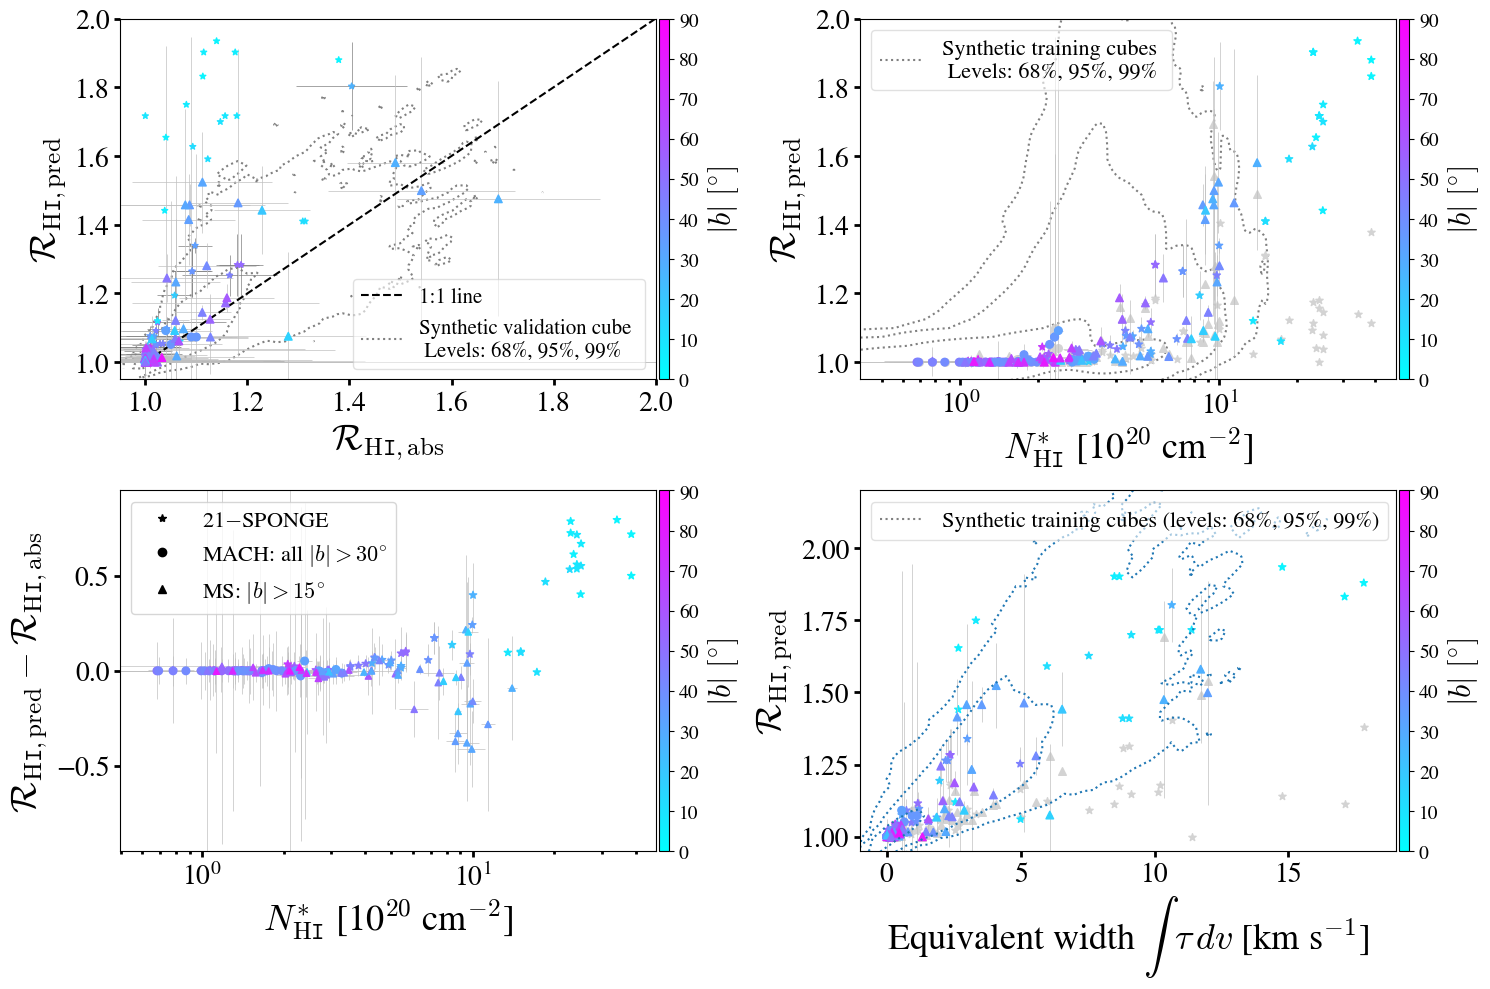

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

cm = 'cool'



############
ax = axs[0,0]

sct1 = ax.scatter(sp21_rhi, ct_rhi,
                   zorder=2, s=20,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.errorbar(sp21_rhi, ct_rhi,
             xerr=sp21_sigrhi, yerr=ct_sigrhi, zorder=1,
             color='gray', marker='o', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')


ax.scatter(sp20_rhi, ct0_rhi,
                   zorder=2, s=20,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.plot([1., 2.], [1., 2.], 'k--', label='1:1 line')




ax.scatter(m_rhi, ctm_rhi,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.errorbar(m_rhi, ctm_rhi,
             xerr=m_sigrhi, yerr=ctm_sigrhi, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')





ax.scatter(ms_rhi, ctms_rhi,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax.errorbar(ms_rhi, ctms_rhi,
             xerr=ms_sigrhi, yerr=0.5*ctms_sigrhi, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')




x,y = z_gt_flat, z_pred_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax, levels=[0.01, 0.05, 0.32], linestyles=':', color='gray', zorder=-2)



ploti, = ax.plot([], [], ls=':', color='gray', label='Synthetic validation cube \n Levels: 68%, 95%, 99%')
ploti.set_visible(True)


ax.set_xlabel('$\mathcal{R}_\mathrm{H\mathtt{I}, abs}$', fontsize=26)
ax.set_ylabel('$\mathcal{R}_\mathrm{H\mathtt{I}, pred}$', fontsize=26, fontweight='normal')

ax.set_xlim(0.95, 2.)
ax.set_ylim(0.95, 2.)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)



## Color bar
cbar = fig.colorbar(sct0, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax.legend(loc='lower right', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=15)







#############
ax = axs[1,0]

sct1 = ax.scatter(nhithin, ct_rhi-sp21_rhi,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ct_sigrhi**2 + sp21_sigrhi**2)
ax.errorbar(nhithin, ct_rhi-sp21_rhi,
             xerr=signhithin, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


ax.scatter(nhithin_m, ctm_rhi-m_rhi,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ctm_sigrhi**2 + m_sigrhi**2)
ax.errorbar(nhithin_m, ctm_rhi-m_rhi,
             xerr=signhithin_m, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')



ax.scatter(nhithin0, ct0_rhi-sp20_rhi,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.scatter(ms_nhithin, ms_rhi-ctms_rhi,
                   zorder=2, s=20,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( (0.5*ctms_sigrhi)**2 + ms_sigrhi**2)
ax.errorbar(ms_nhithin, ms_rhi-ctms_rhi,
             xerr=ms_signhithin, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

# Background
ploti, = ax.plot([], [], 'k*', label=r'21$-$SPONGE')
ploti.set_visible(True)


ploti, = ax.plot([], [], 'ko', label=r'MACH: all $|b| > 30^{\circ}$')
ploti.set_visible(True)


ploti, = ax.plot([], [], 'k^', label=r'MS: $|b| > 15^{\circ}$')
ploti.set_visible(True)



# ax.set_title(f'Sightlines toward LMC excluded')
ax.set_xlabel(r'$N^{*}_\mathrm{H\mathtt{I}}$ [10$^{20}$ cm$^{-2}$]', fontsize=26)
ax.set_ylabel('$\mathcal{R}_\mathrm{H\mathtt{I}, pred} - \mathcal{R}_\mathrm{H\mathtt{I}, abs}$', fontsize=26, fontweight='normal')

ax.set_xscale('log')

ax.set_ylim(-0.95, 0.95)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct1, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax.legend(loc='upper left', fancybox=True, framealpha=0.8, labelcolor='k', fontsize=16)











#############
ax = axs[0,1]


sct0 = ax.scatter(nhithin, ct_rhi,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.scatter(nhithin, sp21_rhi,
                   zorder=0, s=30,
                   marker='*', c='lightgray', label='')

ax.scatter(nhithin0, sp20_rhi,
                   zorder=0, s=30,
                   marker='*', c='lightgray', label='')

ax.errorbar(nhithin, ct_rhi,
             xerr=sp21_sigrhi, yerr=ct_sigrhi, zorder=1,
             color='silver', marker='*', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax.scatter(nhithin0, ct0_rhi,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')


ax.scatter(nhithin_m, ctm_rhi,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.errorbar(nhithin_m, ctm_rhi,
             xerr=m_sigrhi, yerr=ctm_sigrhi, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax.scatter(nhithin_m, m_rhi,
                   zorder=0, s=30,
                   marker='o', c='lightgray', label='')





ax.scatter(ms_nhithin, ctms_rhi,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax.scatter(ms_nhithin, ms_rhi,
                   zorder=0, s=30,
                   marker='^', c='lightgray',
                   label='')

ax.errorbar(ms_nhithin, ctms_rhi,
             xerr=ms_sigrhi, yerr=0.5*ctms_sigrhi, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')



x,y = NHI_flat, RHI_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax, levels=[0.01, 0.05, 0.32], linestyles=':', zorder=-2, color='gray')

ploti, = ax.plot([], [], ls=':', color='gray', label='Synthetic training cubes \n Levels: 68%, 95%, 99%')
ploti.set_visible(True)


ax.set_xlabel(r'$N^{*}_\mathrm{H\mathtt{I}}$ [10$^{20}$ cm$^{-2}$]', fontsize=26)
ax.set_ylabel(r'$\mathcal{R}_\mathrm{H\mathtt{I}, pred}$', fontsize=26, fontweight='normal')



ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_ylim(0.95, 2.)

ax.set_xscale('log')


## Color bar
cbar = fig.colorbar(sct0, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax.legend(loc='upper left', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=16)





#############
ax_main = axs[1,1]



sct0 = ax_main.scatter(sp21_ew, ct_rhi,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(sp21_ew, sp21_rhi,
                   zorder=0, s=30,
                   marker='*', c='lightgray',
                   label='')

ax_main.errorbar(sp21_ew, ct_rhi,
             xerr=sp21_sigew, yerr=ct_sigrhi, zorder=1,
             color='silver', marker='*', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax_main.scatter(sp20_ew, ct0_rhi,
                   zorder=1, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(sp20_ew, sp20_rhi,
                   zorder=0, s=30,
                   marker='*', c='lightgray',
                   label='')







ax_main.scatter(m_ew, ctm_rhi,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(m_ew, m_rhi,
                   zorder=0, s=30,
                   marker='o', c='lightgray',
                   label='')

ax_main.errorbar(m_ew, ctm_rhi,
             xerr=m_sigew, yerr=ctm_sigrhi, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')



ax_main.scatter(ms_ew, ctms_rhi,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax_main.scatter(ms_ew, ms_rhi,
                   zorder=0, s=30,
                   marker='^', c='lightgray',
                   label=r'')

ax_main.errorbar(ms_ew, ctms_rhi,
             xerr=ms_sigew, yerr=0.5*ctms_sigrhi, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


x,y = EW_flat, RHI_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax_main, levels=[0.01, 0.05, 0.32], linestyles=':')




ploti, = ax_main.plot([], [], ls=':', color='gray', label='Synthetic training cubes (levels: 68%, 95%, 99%)')
ploti.set_visible(True)


ax_main.set_xlabel(r'Equivalent width $\int ~ \tau \,dv$ [km s$^{-1}$]', fontsize=26)
ax_main.set_ylabel(r'$\mathcal{R}_\mathrm{H\mathtt{I}, pred}$', fontsize=26, fontweight='normal')

ax_main.set_xlim(-1., 19.)
ax_main.set_ylim(0.95, 2.2)

ax_main.tick_params(axis='x', labelsize=20, pad=4)
ax_main.tick_params(axis='y', labelsize=20)
ax_main.tick_params(which='both', width=2)
ax_main.tick_params(which='major', length=4)
ax_main.tick_params(which='minor', length=2)


## Color bar
cbar = fig.colorbar(sct0, ax=ax_main, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)


ax_main.legend(loc='upper left', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=16)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

plt.tight_layout()


plt.show()

# Comparison: $f_\mathrm{CNM}$

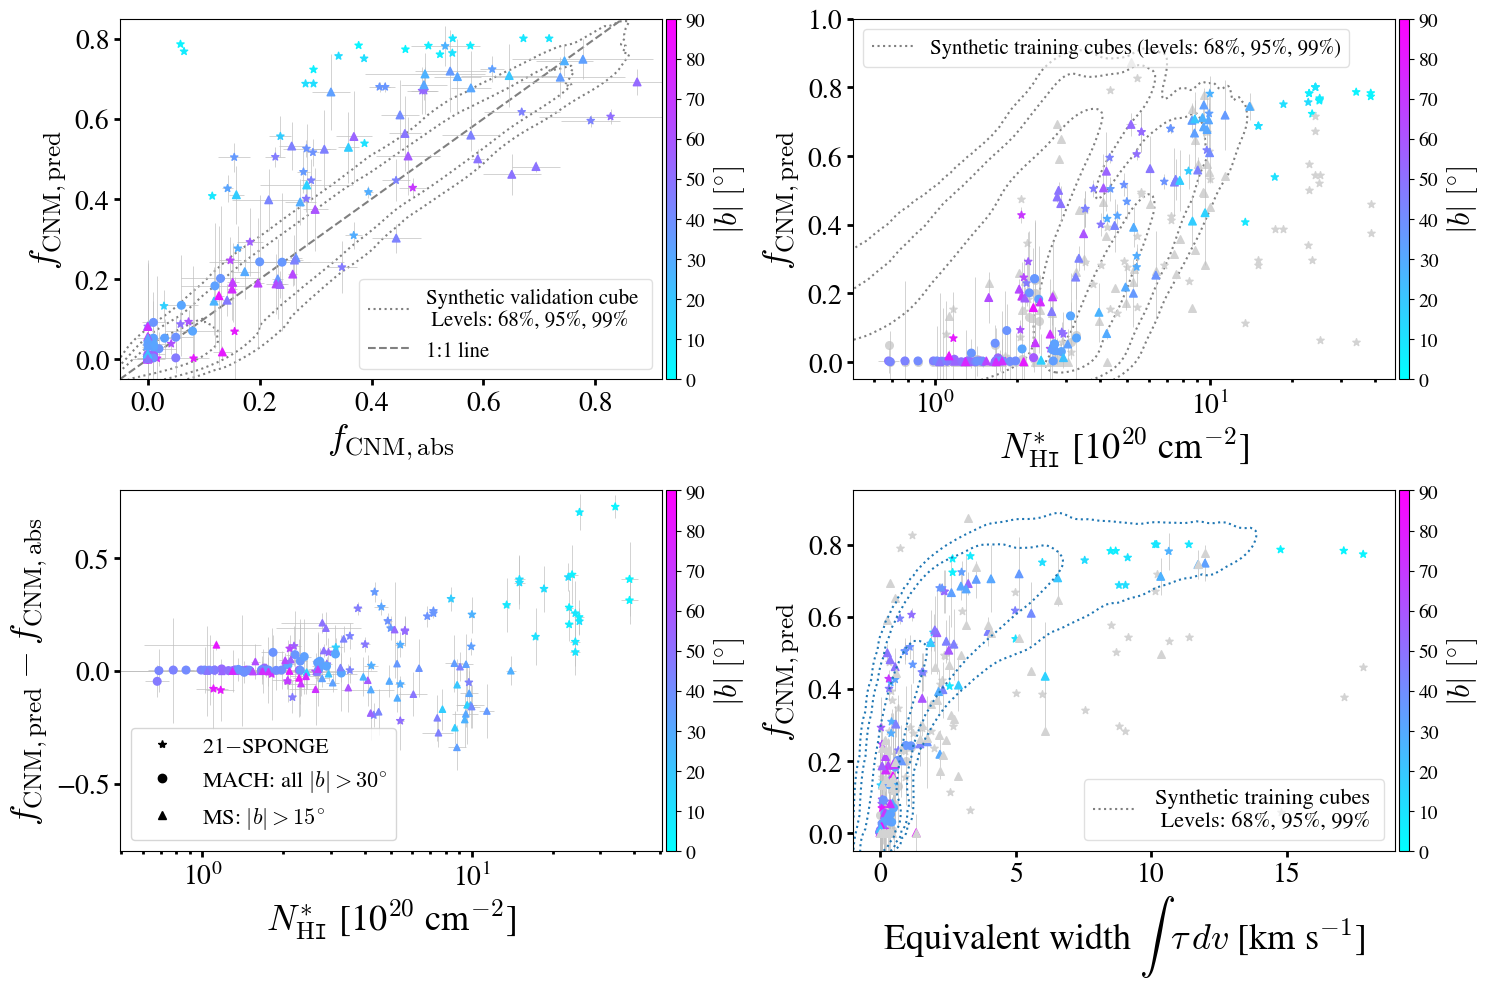

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

cm = 'cool'



############
ax = axs[0,0]

sct0 = ax.scatter(sp21_fcnm, ct_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.errorbar(sp21_fcnm, ct_fcnm,
             xerr=sp21_sigfcnm, yerr=ct_sigfcnm, zorder=1,
             color='silver', marker='*', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax.scatter(sp20_fcnm, ct0_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')



ax.scatter(m_fcnm, ctm_fcnm,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.errorbar(m_fcnm, ctm_fcnm,
             xerr=m_sigfcnm, yerr=ctm_sigfcnm, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')





ax.scatter(ms_fcnm, ctms_fcnm,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax.errorbar(ms_fcnm, ctms_fcnm,
             xerr=ms_sigfcnm, yerr=ctms_sigfcnm, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')




x,y = y_gt_flat, y_pred_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax, levels=[0.01, 0.05, 0.32], linestyles=':', color='gray', zorder=-2)


ploti, = ax.plot([], [], ls=':', color='gray', label='Synthetic validation cube \n Levels: 68%, 95%, 99%')
ploti.set_visible(True)

ax.plot([-0.05, 1.], [-0.05, 1.], ls='--', c='gray', zorder=-1, label='1:1 line')


ax.set_xlabel(r'$f_\mathrm{CNM, abs}$', fontsize=26)
ax.set_ylabel(r'$f_\mathrm{CNM, pred}$', fontsize=26, fontweight='normal')

ax.set_xlim(-0.05, 0.92)
ax.set_ylim(-0.05, 0.85)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)



## Color bar
cbar = fig.colorbar(sct0, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax.legend(loc='lower right', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=15)







#############
ax = axs[1,0]

sct1 = ax.scatter(nhithin, ct_fcnm-sp21_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ct_sigfcnm**2 + sp21_sigfcnm**2)
ax.errorbar(nhithin, ct_fcnm-sp21_fcnm,
             xerr=signhithin, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


ax.scatter(nhithin_m, ctm_fcnm-m_fcnm,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ctm_sigfcnm**2 + m_sigfcnm**2)
ax.errorbar(nhithin_m, ctm_fcnm-m_fcnm,
             xerr=signhithin_m, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax.scatter(nhithin0, ct0_fcnm-sp20_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ct0_sigfcnm**2 + sp20_sigfcnm**2)
ax.errorbar(nhithin0, ct0_fcnm-sp20_fcnm,
             xerr=signhithin0, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


ax.scatter(ms_nhithin, ms_fcnm-ctms_fcnm,
                   zorder=2, s=20,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')
yyerr = np.sqrt( ctms_sigfcnm**2 + ms_sigfcnm**2)
ax.errorbar(ms_nhithin, ms_fcnm-ctms_fcnm,
             xerr=ms_signhithin, yerr=yyerr, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')



# Background
ploti, = ax.plot([], [], 'k*', label=r'21$-$SPONGE')
ploti.set_visible(True)


ploti, = ax.plot([], [], 'ko', label=r'MACH: all $|b| > 30^{\circ}$')
ploti.set_visible(True)


ploti, = ax.plot([], [], 'k^', label=r'MS: $|b| > 15^{\circ}$')
ploti.set_visible(True)

ax.set_xlabel(r'$N^{*}_\mathrm{H\mathtt{I}}$ [10$^{20}$ cm$^{-2}$]', fontsize=26)
ax.set_ylabel(r'$f_\mathrm{CNM, pred} - f_\mathrm{CNM, abs}$', fontsize=26, fontweight='normal')

ax.set_xscale('log')

ax.set_ylim(-0.8, 0.8)

ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(sct1, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)


ax.legend(loc='lower left', fancybox=True, framealpha=0.8, labelcolor='k', fontsize=16)



#############
ax = axs[0,1]

sct0 = ax.scatter(nhithin, ct_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.scatter(nhithin, sp21_fcnm,
                   zorder=0, s=30,
                   marker='*', c='lightgray',
                   label='')


ax.errorbar(nhithin, ct_fcnm,
             xerr=sp21_sigfcnm, yerr=ct_sigfcnm, zorder=1,
             color='silver', marker='*', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


ax.scatter(nhithin0, ct0_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.scatter(nhithin0, sp20_fcnm,
                   zorder=2, s=30,
                   marker='*', c='lightgray',
                   label='')


ax.scatter(nhithin_m, ctm_fcnm,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax.scatter(nhithin_m, m_fcnm,
                   zorder=0, s=30,
                   marker='o', c='lightgray',
                   label='')


ax.errorbar(nhithin_m, ctm_fcnm,
             xerr=m_sigfcnm, yerr=ctm_sigfcnm, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')





ax.scatter(ms_nhithin, ctms_fcnm,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax.scatter(ms_nhithin, ms_fcnm,
                   zorder=0, s=30,
                   marker='^', c='lightgray',
                   label=r'')

ax.errorbar(ms_nhithin, ctms_fcnm,
             xerr=ms_sigfcnm, yerr=ctms_sigfcnm, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


x,y = NHI_flat, FCNM_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax, levels=[0.01, 0.05, 0.32], linestyles=':', zorder=-2, color='gray')

ploti, = ax.plot([], [], ls=':', color='gray', label='Synthetic training cubes (levels: 68%, 95%, 99%)')
ploti.set_visible(True)


ax.set_xlabel(r'$N^{*}_\mathrm{H\mathtt{I}}$ [10$^{20}$ cm$^{-2}$]', fontsize=26)
ax.set_ylabel(r'$f_\mathrm{CNM, pred}$', fontsize=26, fontweight='normal')



ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_ylim(-0.05, 1.)
ax.set_xscale('log')

## Color bar
cbar = fig.colorbar(sct0, ax=ax, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax.legend(loc='upper left', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=15)







#############
ax_main = axs[1,1]

sct0 = ax_main.scatter(sp21_ew, ct_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp21_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(sp21_ew, sp21_fcnm,
                   zorder=0, s=30,
                   marker='*', c='lightgray',
                   label='')

ax_main.errorbar(sp21_ew, ct_fcnm,
             xerr=sp21_sigew, yerr=ct_sigfcnm, zorder=1,
             color='silver', marker='*', ls='None', markersize=2,
             markeredgecolor='gray', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')

ax_main.scatter(sp20_ew, ct0_fcnm,
                   zorder=2, s=30,
                   marker='*', c=sp20_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(sp20_ew, sp20_fcnm,
                   zorder=0, s=30,
                   marker='*', c='lightgray',
                   label='')

ax_main.scatter(m_ew, ctm_fcnm,
                   zorder=2, s=30,
                   marker='o', c=m_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label='')

ax_main.scatter(m_ew, m_fcnm,
                   zorder=0, s=30,
                   marker='o', c='lightgray',
                   label='')

ax_main.errorbar(m_ew, ctm_fcnm,
             xerr=m_sigew, yerr=ctm_sigfcnm, zorder=1,
             color='silver', marker='o', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')



ax_main.scatter(ms_ew, ctms_fcnm,
                   zorder=2, s=30,
                   marker='^', c=ms_lat, cmap=cm,
                   vmin=0.,
                   vmax=90.,
                   label=r'')

ax_main.scatter(ms_ew, ms_fcnm,
                   zorder=2, s=30,
                   marker='^', c='lightgray',
                   label=r'')

ax_main.errorbar(ms_ew, ctms_fcnm,
             xerr=ms_sigew, yerr=ctms_sigfcnm, zorder=1,
             color='silver', marker='^', ls='None', markersize=2,
             markeredgecolor='silver', markeredgewidth=1,
             ecolor='silver', elinewidth=0.5,
             label='')


x,y = EW_flat, FCNM_flat
indices = np.random.choice(len(x), size=99_000, replace=False)
x,y = x[indices], y[indices]
tdata = {
    'x' : x,
    'y' : y
}
del x, y, indices
sns.kdeplot(data=tdata, x='x', y='y', ax=ax_main, levels=[0.01, 0.05, 0.32], linestyles=":")


ploti, = ax_main.plot([], [], ls=':', color='gray', label='Synthetic training cubes \n Levels: 68%, 95%, 99%')
ploti.set_visible(True)


ax_main.set_xlabel(r'Equivalent width $\int ~ \tau \,dv$ [km s$^{-1}$]', fontsize=26)
ax_main.set_ylabel(r'$f_\mathrm{CNM, pred}$', fontsize=26, fontweight='normal')

ax_main.set_xlim(-1., 19.)
ax_main.set_ylim(-0.05, 0.95)

ax_main.tick_params(axis='x', labelsize=20, pad=4)
ax_main.tick_params(axis='y', labelsize=20)
ax_main.tick_params(which='both', width=2)
ax_main.tick_params(which='major', length=4)
ax_main.tick_params(which='minor', length=2)


## Color bar
cbar = fig.colorbar(sct0, ax=ax_main, orientation='vertical', fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$|b|~[^{\circ}]$', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=14)

ax_main.legend(loc='lower right', fancybox=True, framealpha=0.6, labelcolor='k', fontsize=16)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

plt.tight_layout()


plt.show()

# End